In [1]:
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),  # Increased rotation angle
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),  # Increased intensity
    transforms.RandomResizedCrop(224),  # Random resized crop
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Load CSV
csv_path = 'er_status_all_data.csv'
dataframe = pd.read_csv(csv_path)

In [4]:
#Splitting datasets (70% training, 10% validation, 20% test)
train_data, remaining_data = train_test_split(dataframe, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(remaining_data, test_size=0.67, random_state=42)

In [5]:
# Initialize datasets
train_dataset = CustomDataset(train_data, root_dir='/Users/VanKhai/Desktop/TCGA_BRCA_Histology/', transform=transform)
val_dataset = CustomDataset(val_data, root_dir='/Users/VanKhai/Desktop/TCGA_BRCA_Histology/', transform=transform)
test_dataset = CustomDataset(test_data, root_dir='/Users/VanKhai/Desktop/TCGA_BRCA_Histology/', transform=transform)

# Initialize dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Define CNN model
import torch.nn as nn
import torchvision.models as models

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        x = self.resnet(x)
        return x

# Initialize model
model = CustomCNN().to(device)

/Users/VanKhai/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/VanKhai/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels_tuple in train_dataloader:  
        labels = torch.tensor([1 if label == 'Positive' else 0 for label in labels_tuple]).float().to(device)
        inputs = images.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f'Training Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Training Epoch [1/5], Loss: 0.7015
Training Epoch [2/5], Loss: 0.6565
Training Epoch [3/5], Loss: 0.6549
Training Epoch [4/5], Loss: 0.6418
Training Epoch [5/5], Loss: 0.6246


In [10]:
from sklearn.metrics import f1_score
import numpy as np

test_loss = 0.0
correct_predictions = 0
total_samples = len(test_dataset)

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels_tuple in test_dataloader:
        labels = torch.tensor([1 if label == 'Positive' else 0 for label in labels_tuple]).to(device)
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        loss = criterion(outputs.squeeze(), labels.float())
        test_loss += loss.item() * inputs.size(0)

test_loss /= len(test_dataset)

binary_predictions = [1 if pred > 0.5 else 0 for pred in all_predictions]
f1 = f1_score(all_labels, binary_predictions)

accuracy = sum(np.array(all_labels) == np.array(binary_predictions)) / len(all_labels)

print(f'Test Loss: {test_loss:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Test Loss: 0.5941
F1 Score: 0.7512
Accuracy: 0.6871


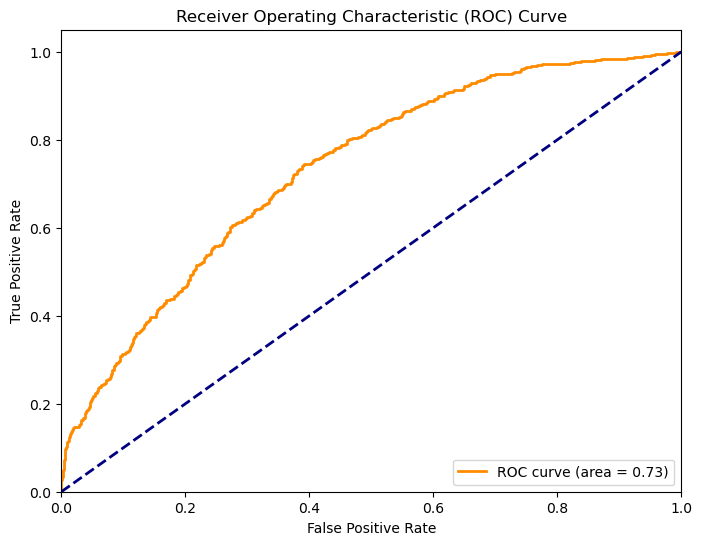

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Convert predictions and labels to numpy arrays
all_predictions_np = np.array(all_predictions)
all_labels_np = np.array(all_labels)

# Calculate fpr and tpr
fpr, tpr, thresholds = roc_curve(all_labels_np, all_predictions_np)

# Calculate AUC
auc = roc_auc_score(all_labels_np, all_predictions_np)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show() 